<a href="https://colab.research.google.com/github/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part2/encoder-decoder_image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Description In Encoder-Decoder Frameworks

In this tutorial, you get familar with applications of pretrained convolutional neural networks (ConvNets) in visual understanding, especially for image description. 

In [0]:
%matplotlib inline

## library
# GPU selection (if needed)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from matplotlib import pyplot as plt

from glob import glob

from itertools import combinations
from scipy.spatial.distance import cosine
import pandas as pd

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K




## Object Recognition With ConvNets

Object recogntion is one of the basic tasks in visual understanding. With a limited list of objects it simply becomes a classification task. For example, ILSVRC-2013 (ImageNet) provides largest dataset of pictures in 1000 categories of object names in English language.
The state of the art models in this task are based on some variations of Convolutional Neural Networks.

Here is an example of how such model can be used for object classification.


In [8]:
# The model here: https://arxiv.org/abs/1512.03385
# Pre-trained on ImageNet object recogntion:
obj_recognition_model = ResNet50(weights='imagenet')

W0815 14:26:59.560659 140709022066560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


102858752/102853048 [==============================] - 1s 0us/step


In [0]:
# download few sample images
! wget -q https://gubox.box.com/shared/static/ois9pg8t2j65ir8lhcapo7e3yctzwj27.jpg 
! wget -q https://gubox.box.com/shared/static/7yo0mhiz8wi81ysfbgjns6f2cgsc80yk.jpg 
! wget -q https://gubox.box.com/shared/static/8yzk194f3flmctzqe344fq39deyhanl6.jpg 
! wget -q https://gubox.box.com/shared/static/vpg4gc5k1xocp0r9y5tyfjqtphr7ntj2.jpg 
! wget -q https://upload.wikimedia.org/wikipedia/commons/a/ab/Volleyball_dig.jpg
! mkdir sample_images
! mv 7yo0mhiz8wi81ysfbgjns6f2cgsc80yk.jpg sample_images/volleyball.jpg
! mv vpg4gc5k1xocp0r9y5tyfjqtphr7ntj2.jpg sample_images/shovel.jpg
! mv 8yzk194f3flmctzqe344fq39deyhanl6.jpg sample_images/bicycle.jpg
! mv ois9pg8t2j65ir8lhcapo7e3yctzwj27.jpg sample_images/potter.jpg
! mv Volleyball_dig.jpg sample_images/volleyball_def.jpg
# similarly you can download any image in sample_images directory.

In [0]:
# read images
# represent them in numpy array
# preprocessed images for object recognition

img_paths = [
    path
    for path in glob('sample_images/*.jpg')
]

imgs = np.array([
    image.img_to_array(image.load_img(img_path, target_size=(224, 224)))
    for img_path in img_paths
])

x = preprocess_input(imgs)

40960/35363 [==================================] - 0s 0us/step


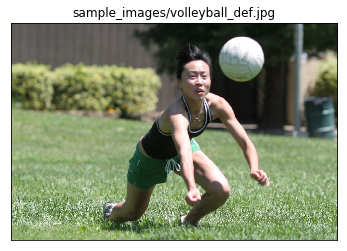

0.994 rugby_ball
0.003 soccer_ball
0.003 volleyball
0.000 baseball
0.000 golf_ball


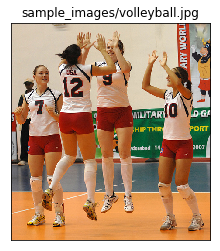

0.926 volleyball
0.028 knee_pad
0.018 basketball
0.009 soccer_ball
0.006 miniskirt


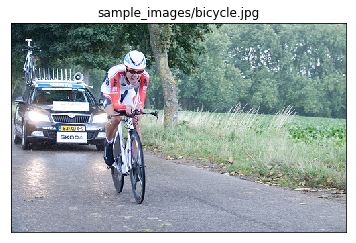

0.951 jinrikisha
0.035 bicycle-built-for-two
0.003 tricycle
0.002 horse_cart
0.002 moped


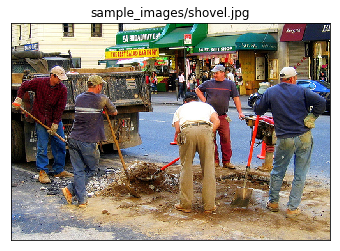

0.268 shovel
0.196 swab
0.154 chain_saw
0.067 broom
0.043 jinrikisha


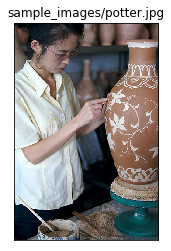

0.905 potter's_wheel
0.055 water_jug
0.026 vase
0.004 milk_can
0.003 pitcher


In [9]:
# predictions: (probability of each class) 
y_preds = obj_recognition_model.predict(x)

# convert the probabilities into object names sorted based on probabilities:
preds = decode_predictions(y_preds)

# plot and print
for i, (img_path, pred) in enumerate(zip(img_paths, preds)):
  print('====' * 10)
  plt.imshow(plt.imread(img_path))
  plt.xticks([])
  plt.yticks([])
  plt.title(img_path)
  plt.show()
  # print top 5:
  for _, obj_name, obj_prob in pred[:5]:  
    print(f"{obj_prob:.3f} {obj_name}")
  print('====' * 10)


## Visual Feature Extraction With Pre-trained ConvNets

The outputs of intermediate layers in ConvNets can be used as basic representation of the image for many other tasks. 

In [3]:
# By excluding the top-layer, the output of the model for each image is going to be a tensor of (7 x 7 x 2048)
convnet_model = ResNet50(weights='imagenet', input_shape=[224, 224, 3],  include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
visual_features = convnet_model.predict(x)

In [11]:
print("The model's output shape:", visual_features.shape)
# number of images, 
# 7 x 7 regions
# feature vector per region.

The model's output shape: (5, 7, 7, 2048)


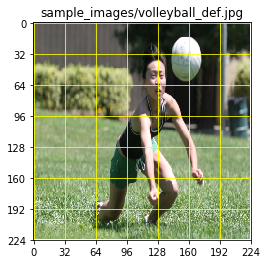

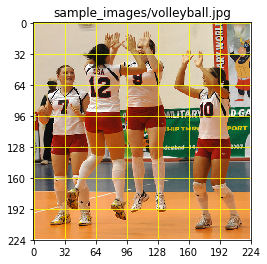

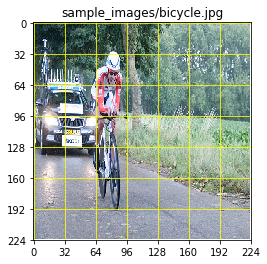

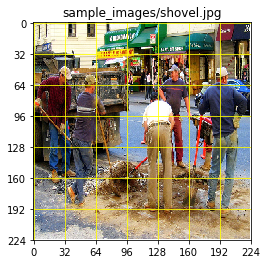

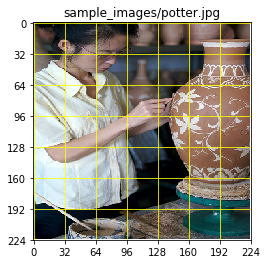

In [12]:
# The 7 x 7 dimensions corresponds to 7 x 7 regions in the picture. 
# In other words, each region is represented with a 2048-dimension vector.
for i, img_path in enumerate(img_paths):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.xticks(range(0, 225, 32))
    plt.yticks(range(0, 225, 32))
    plt.title(img_path)
    plt.grid(True, color='yellow')
    plt.show()

#### What Do These Features Represent?

Training for the object-recognition with Convolutional Neural Networks is a bottom-up visual understanding process.
Each image is represented with features which could potentially predicts *what* is in the pictures.


In [13]:
print(f'Each image is represented with a {visual_features[0].flatten().shape[0]}-dimension vector.')

Each image is represented with a 100352-dimension vector.


In [14]:
# We can directly compare the similarity of two pictures
# By comparing the similarity between their vectors

# build a matrix of all images:
df = pd.DataFrame(
    np.ones([len(img_paths), len(img_paths)]),
    index=[im.replace('sample_images/', '') for im in img_paths],
    columns=[im.replace('sample_images/', '') for im in img_paths]
)

# compare images with each other, update the matrix:
for (i, img1), (j, img2) in combinations(enumerate(df.index), 2):
  d = cosine(visual_features[i,3,3].flatten(), visual_features[j,3,3].flatten())
  df[img1][img2] = 1 - d
  df[img2][img1] = 1 - d
  
df

,volleyball_def.jpg,volleyball.jpg,bicycle.jpg,shovel.jpg,potter.jpg
volleyball_def.jpg,1.000000,0.228478,0.178142,0.172595,0.153955
volleyball.jpg,0.228478,1.000000,0.197069,0.281667,0.132571
bicycle.jpg,0.178142,0.197069,1.000000,0.345422,0.117031
shovel.jpg,0.172595,0.281667,0.345422,1.000000,0.265670
potter.jpg,0.153955,0.132571,0.117031,0.265670,1.000000


## Decode With Conditional Language Model

We trained a simple condigional language model on Flickr30K corpus, conditioned with visual features from pre-trained ResNet50 model.

In [0]:
# download the caption model
! wget -q https://gubox.box.com/shared/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5
! mv 3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5 simple_caption_model.h5

In [0]:
_visual_features = visual_features.reshape([visual_features.shape[0], 49, 2048])
caption_model = load_model("simple_caption_model.h5")


In [0]:
# download language coding info about the decoder
! mkdir preprocessed_flickr30k
! wget -q https://gubox.box.com/shared/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy
! mv 7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy preprocessed_flickr30k/ix2word.npy

In [0]:
max_len = 25
ix2word = np.load('preprocessed_flickr30k/ix2word.npy', allow_pickle=True)[None][0]
word2ix = {w: ix for ix, w in ix2word.items()}

def sent2ixs(sent):
    return [word2ix['<s>']]+[word2ix[w] for w in sent]+[word2ix['</s>']]+[word2ix['<pad/>']]*(max_len-len(sent))

def ixs2sent(ixs):
    return [ix2word[ix] for ix in ixs if ix2word[ix] != '<pad/>']

## How It works?

#### Likelihood Of Descriptions

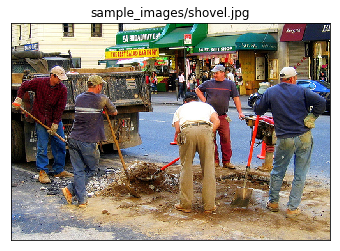

In [0]:
# choose an image here
image_index = 2
plt.imshow(plt.imread(img_paths[image_index]))
plt.xticks([])
plt.yticks([])
plt.title(img_paths[image_index])
plt.show()


In [0]:
# propose a few sentences which describes the image:
sents = np.array([
    sent2ixs("a group of men are standing .".split(" ")),
    sent2ixs("a group of men are working .".split(" ")),
    sent2ixs("a group of men with hat are working .".split(" ")),
    sent2ixs("a group of men with cat are working .".split(" ")),
    sent2ixs("people are celebrating on street .".split(" ")),
])


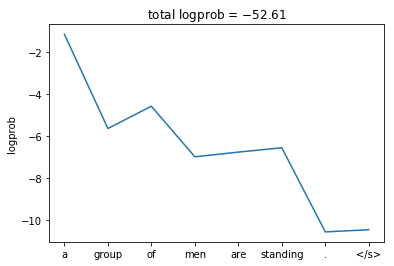

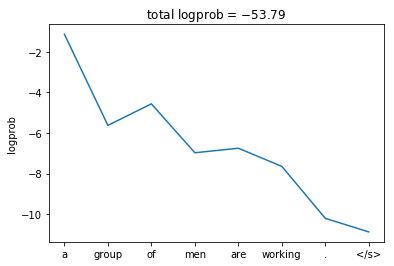

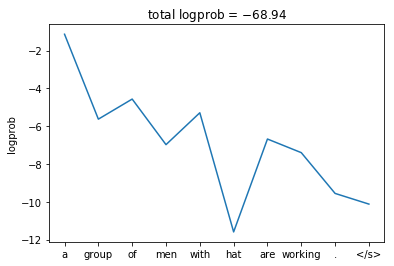

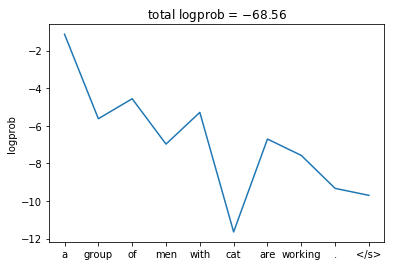

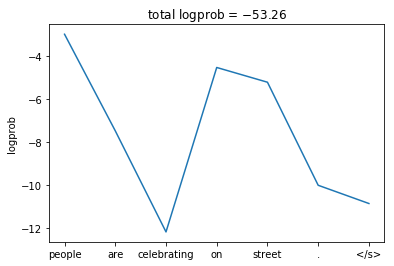

In [0]:
# repeat the image for all test sentences:
vfs = np.array([_visual_features[image_index]] * len(sents))

# predict the token probabilities with the given sentnece and the visual features:
sents_prs = caption_model.predict([sents[:, :-1], vfs])
for sent, prs in zip(sents[:, 1:], sents_prs):
    words_prs = [
        (ix2word[ixw], pr[ixw])
        for pr, ixw in zip(prs, sent)
        if ix2word[ixw] not in {'<pad/>'}
    ]
    
    words, prs = zip(*words_prs)
    
    logprobs = np.log(prs)
    plt.title("total logprob = ${0:.2f}$".format(logprobs.sum()))
    plt.plot(logprobs)
    plt.xticks(range(len(words)), words)
    plt.ylabel("logprob")
    plt.show()
    

#### Beam Search for caption generation

In order to find the best word sequence, incrementally we can search among possible choices in $P(w_{t+1} | I, w_1, w_2, ..., w_t)$



In [0]:
# This implementation only accepts one source image as source input.
def search(model, src_input, k=1, sequence_max_len=25):
    # (log(1), initialize_of_zeros)
    k_beam = [(0, [word2ix['<s>'],word2ix['</s>']]+[word2ix['<pad/>']]*(sequence_max_len-1))]

    # l : point on target sentence to predict
    for l in range(sequence_max_len):
        all_k_beams = []
        for prob, sent_predict in k_beam:
            predicted = model.predict([np.array([sent_predict]), np.array([src_input])])[0]
            # top k!
            possible_k = predicted[l].argsort()[-k:][::-1]

            # add to all possible candidates for k-beams
            all_k_beams += [
                (
                    sum(np.log(predicted[i][sent_predict[i+1]]) for i in range(l)) + np.log(predicted[l][next_wid]),
                    list(sent_predict[:l+1])+[next_wid]+[0]*(sequence_max_len-l-1)
                )
                for next_wid in possible_k
            ]

        # top k
        k_beam = sorted(all_k_beams)[-k:][::-1]

    return k_beam

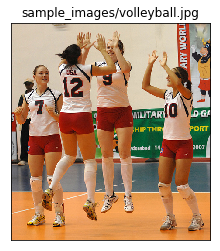

Top 5 beams:
logprob=-41.75 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball
logprob=-42.00 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two two
logprob=-42.11 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two two basketball two basketball two basketball two
logprob=-42.18 sent=a basketball two basketball two basketball two basketball two basketball two basketball two two basketball two basketball two basketball two basketball two basketball two
logprob=-42.27 sent=a basketball two basketball two basketball two two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two


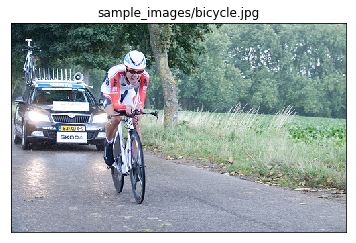

Top 5 beams:
logprob=-16.95 sent=a a a a a a a a a a a a a a a a a a a a a a a a
logprob=-18.09 sent=a a a a a a a a a a a a a a a a a a a a a a a a
logprob=-18.71 sent=a a a a a a a a a a a a a a a a a a a a a a man is
logprob=-18.91 sent=a man is a a a a a a a a a a a a a a a a a a a a a
logprob=-18.94 sent=a man a a a a a a a a a a a a a a a a a a a a a a


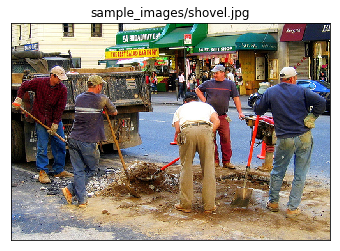

Top 5 beams:
logprob=-37.15 sent=a three a children a front a front a front a front a front a front a front a front a front a front
logprob=-37.35 sent=a three a children a front a front a front a front a front a front a front a front a front front front
logprob=-37.54 sent=a three a children a front a front a front a front a front a front a front a front a front a front
logprob=-37.58 sent=a three a children a front a front a front a front a front a front a front a front a front front a
logprob=-37.61 sent=a three a children a front a front a front a front a front a front a front a front a front front front


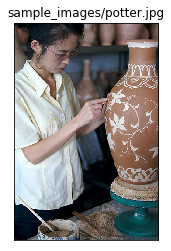

Top 5 beams:
logprob=-26.46 sent=a woman sitting in a woman in a woman in a woman in a woman in a woman in a woman in a woman
logprob=-26.50 sent=a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in
logprob=-27.21 sent=a woman in a woman in a girl in a woman in a woman in a woman in a woman in a woman in
logprob=-27.23 sent=a woman in a girl in a woman in a woman in a woman in a woman in a woman in a woman in
logprob=-27.31 sent=a woman in a woman in a woman in a girl in a woman in a woman in a woman in a woman in


In [0]:
k = 5
for i, vf in enumerate(_visual_features):
    plt.imshow(plt.imread(img_paths[i]))
    plt.xticks([])
    plt.yticks([])
    plt.title(img_paths[i])
    plt.show()
    
    print("Top {0} beams:".format(k))
    top_k = search(caption_model, vf, k=k)
    for logprob, ixs in top_k:
        print("logprob={0:.2f} sent={1}".format(logprob, " ".join(ixs2sent(ixs)[1:-1])))

#### References



```
@article{flickrentitiesijcv,
         author={Bryan A. Plummer and Liwei Wang and Christopher M. Cervantes and Juan C. Caicedo and Julia Hockenmaier and Svetlana Lazebnik},
         title={Flickr30K Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models},
         journal={IJCV},
         volume={123},
         number={1},
         pages={74-93},
         year={2017} 
}
```

